# Lab 4: Image Restoration

For 18-793 Image and Video Processing course. By Sarun Gulyanon.

This Jupyter Notebook demonstrates basic image resotration techniques using OpenCV and NumPy. We will cover:

1. Estimate noise from background patches
2. Adaptive local noise reduction filter
3. Adaptive median filter
4. Wiener filter
5. Radon transform


First import necessary libraries and define some helper functions.

In [1]:
import cv2
import numpy as np
from scipy.signal import convolve2d
from skimage.transform import radon, iradon, rescale
from skimage.data import shepp_logan_phantom
import matplotlib.pyplot as plt

In [ ]:
# !mkdir img
# !wget https://github.com/sgulyano/imgvdoproc/raw/refs/heads/main/img/pout.tif -O img/pout.tif

In [2]:
# Function to display images inline using matplotlib
def show_image(title=["Image"], *img):
    plt.figure(figsize=(5*len(img), 5))
    for i in range(len(img)):
        plt.subplot(1, len(img), i+1)
        plt.imshow(img[i], cmap='gray')
        plt.title(title[i])
        plt.axis('off')
    plt.show()

## 1. Estimate noise from background patches

This process is to estimate the noise level in the image by looking at the background patch with constant intensity. Assume that the noise model follows the Gaussian distribution with zero mean. We can estimate the noise standard deviation by calculating the standard deviation of the intensity values in the background patch.

First, create an image with Gaussian noise.

In [3]:
image_circle = np.zeros((300, 300), dtype=np.uint8)  # Black background
cv2.rectangle(image_circle, (50, 50), (250, 250), 100, -1)  # Gray square
cv2.circle(image_circle, (150, 150), 50, 200, -1)  # Black circle

def add_gaussian_noise(img, mean=0, std=20):
    noisy = img.astype(np.float32)
    gauss = np.random.normal(mean, std, img.shape)
    noisy += gauss
    # Clip to valid range and convert back to uint8
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

sigma = 20
noisy_image_circle = add_gaussian_noise(image_circle, std=sigma)


Then, select a background patch and calculate the standard deviation of the intensity values in the patch.

In [4]:
patch = noisy_image_circle[50:100,50:100]
noise_estimate = np.std(patch)
print(f'Estimated noise: {noise_estimate}')

Estimated noise: 20.134909211615533


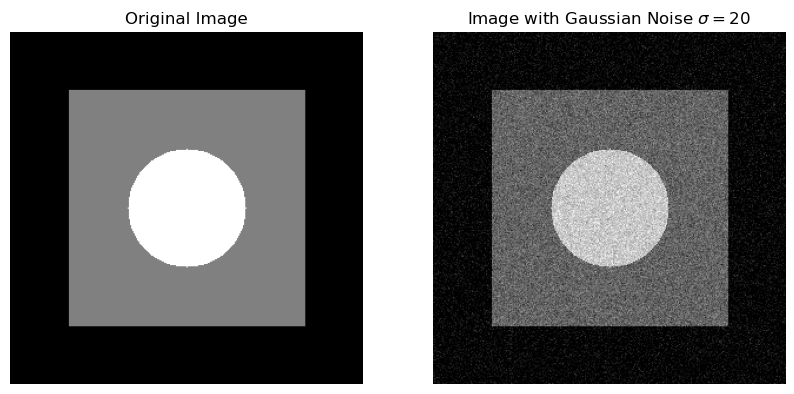

In [5]:
show_image(["Original Image", f"Image with Gaussian Noise $\sigma={sigma}$"], image_circle, noisy_image_circle)

## 2. Adaptive local noise reduction filter

An adaptive local noise reduction filter reduces noise in an image by adjusting the filtering strength based on the local variance of the image, preserving edges and fine details while smoothing homogeneous regions.

Create image with Gaussian noise and apply the adaptive local noise reduction filter.

In [ ]:
# Load image
image = cv2.imread('img/pout.tif', cv2.IMREAD_GRAYSCALE)

In [8]:
sigma = 20
gaus_noisy_image = add_gaussian_noise(image, std=sigma)

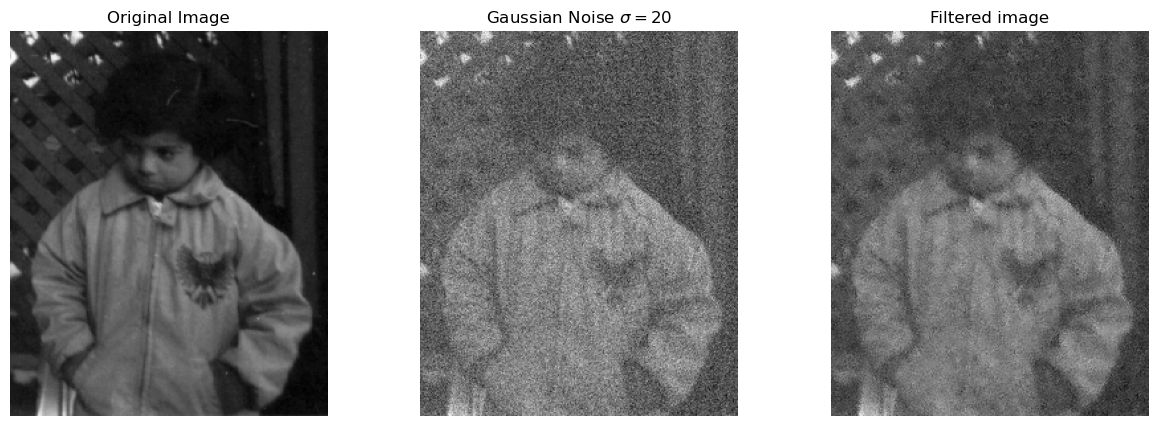

In [11]:
def adaptive_local_noise_reduction_filter(image, window_size=3):
    # Convert image to float32
    image = image.astype(np.float32)
    
    # Calculate the local mean and local variance
    local_mean = cv2.blur(image, (window_size, window_size))
    local_var = cv2.blur(image**2, (window_size, window_size)) - local_mean**2
    
    # Estimate the noise variance (assuming it's constant across the image)
    noise_var = np.mean(local_var)
    
    # Apply the adaptive filter
    result = image - (noise_var / (local_var + noise_var)) * (image - local_mean)
    
    return result.astype(np.uint8)

# Apply the adaptive local noise reduction filter
filtered_image = adaptive_local_noise_reduction_filter(gaus_noisy_image, window_size=7)
show_image(["Original Image", f"Gaussian Noise $\sigma={sigma}$", "Filtered image"], image, gaus_noisy_image, filtered_image)

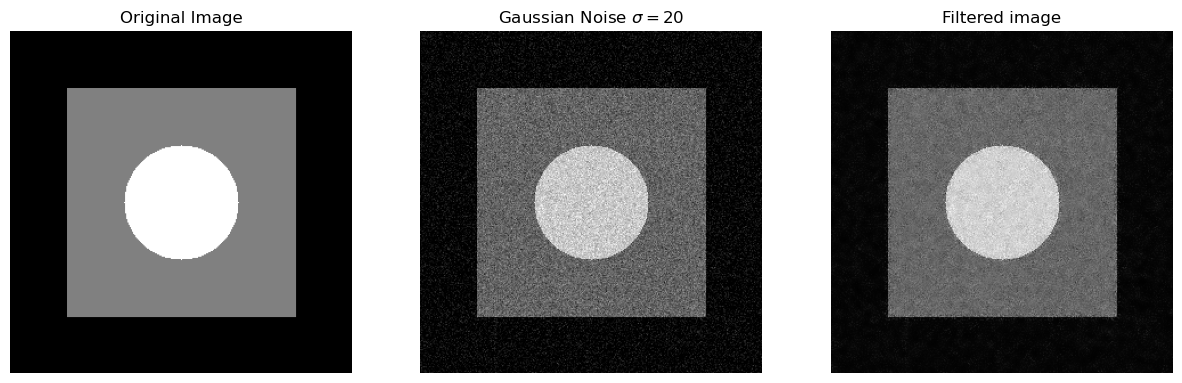

In [ ]:
filtered_image = adaptive_local_noise_reduction_filter(noisy_image_circle, window_size=7)
show_image(["Original Image", f"Gaussian Noise $\sigma={sigma}$", "Filtered image"], image_circle, noisy_image_circle, filtered_image)

## 3. Adaptive median filter

An adaptive median filter reduces noise by dynamically adjusting the filter window size based on local image characteristics, effectively preserving edges while removing salt-and-pepper noise.

Create image with salt-and-pepper noise and apply the adaptive median filter.

In [ ]:
def add_salt_pepper_noise(img, amount=0.02, salt_ratio=0.5):
    noisy = img.copy()
    num_salt = int(amount * img.size * salt_ratio)
    num_pepper = int(amount * img.size * (1.0 - salt_ratio))

    # Salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
    noisy[coords[0], coords[1]] = 255

    # Pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
    noisy[coords[0], coords[1]] = 0

    return noisy

ps = 0.1
pp = 0.1
sp_noisy_image = add_salt_pepper_noise(image, amount=ps+pp, salt_ratio=ps/(ps+pp))

In [13]:
def adaptive_median_filter(image, max_window_size=7):
   
    def adaptive_median(image, x, y, max_window_size):
        window_size = 3
        while window_size <= max_window_size:
            half_size = window_size // 2
            window = image[max(0, x-half_size):min(image.shape[0], x+half_size+1),
                           max(0, y-half_size):min(image.shape[1], y+half_size+1)]
            z_min = np.min(window)
            z_max = np.max(window)
            z_med = np.median(window)
            if z_min < z_med < z_max:
                if z_min < image[x, y] < z_max:
                    return image[x, y]
                else:
                    return z_med
            window_size += 2
        return z_med
    
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            filtered_image[i, j] = adaptive_median(image, i, j, max_window_size)
    
    return filtered_image

# Apply the adaptive median filter
filtered_sp_image = adaptive_median_filter(sp_noisy_image, max_window_size=7)


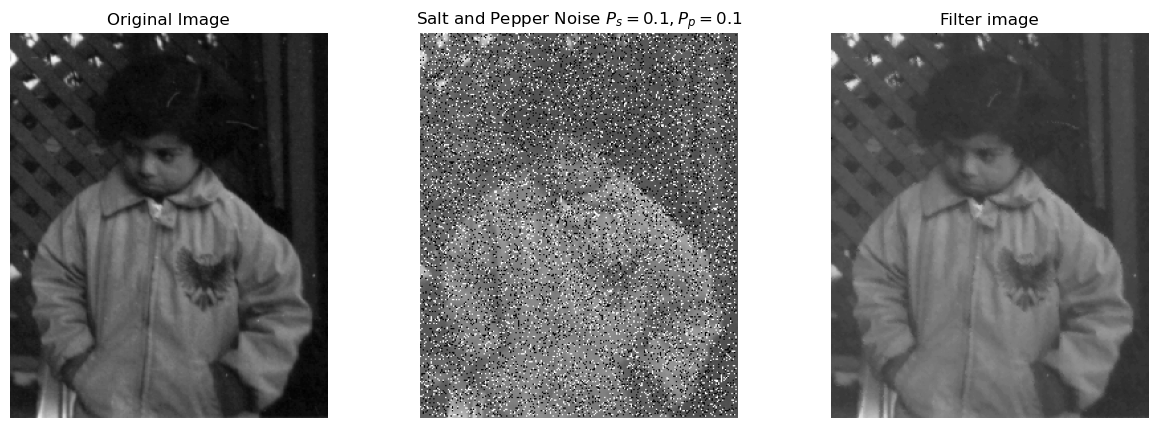

In [ ]:
show_image(["Original Image", f"Salt and Pepper Noise $P_s={ps}, P_p={pp}$", "Filter image"], image, sp_noisy_image, filtered_sp_image)

## 4. Wiener filter

The Wiener filter is a linear filtering technique that reduces noise by minimizing the mean square error between the estimated and true signals. It achieves this by considering both the image and noise power spectra. The Wiener filter is particularly effective when the frequency characteristics of the image and the additive noise are known. In this example, we will apply the Wiener filter to reduce motion blur in the image.

First, create motion-blurred image and apply the Wiener filter.

In [15]:
def motion_blur(image, kernel_size=15):
    # Create a motion blur kernel
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    
    # Apply the motion blur kernel to the image
    blurred = convolve2d(image, kernel, boundary='wrap', mode='same')
    return blurred

# Simulate motion blur
blurred_image = motion_blur(image, kernel_size=15)

In [16]:
def wiener_deblur(blurred_image, kernel, K=0.01):
    kernel /= np.sum(kernel)
    dummy = np.copy(blurred_image)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s=blurred_image.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

# Create a motion blur kernel
kernel = np.zeros((15, 15))
kernel[int((15 - 1) / 2), :] = np.ones(15)
kernel = kernel / 15

# Apply the Wiener filter for deblurring
deblurred_image = wiener_deblur(blurred_image, kernel, K=0.001)


Here is the given kernel or PSF (point spread function) that causes the motion blur.

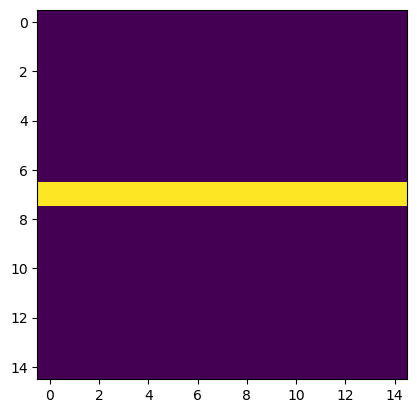

In [16]:
plt.imshow(kernel)

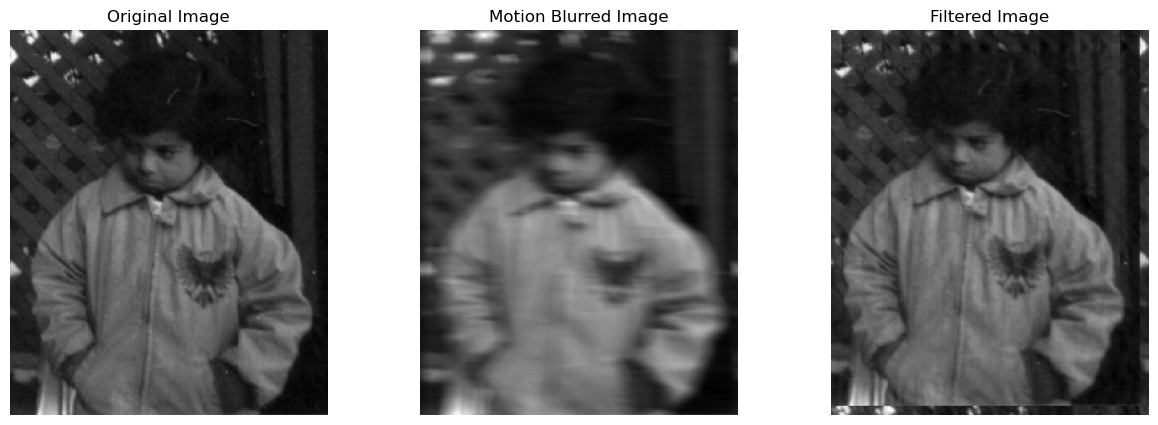

In [ ]:
show_image(["Original Image", "Motion Blurred Image", "Filtered Image"], image, blurred_image, deblurred_image)

## 5. Radon transform

The Radon transform is a mathematical technique that converts a 2D image into a set of projections at different angles, resulting in a representation called a _sinogram_, which is widely used in computed tomography (CT) and image reconstruction.

Reference: https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html

In [19]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

In [20]:
theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)

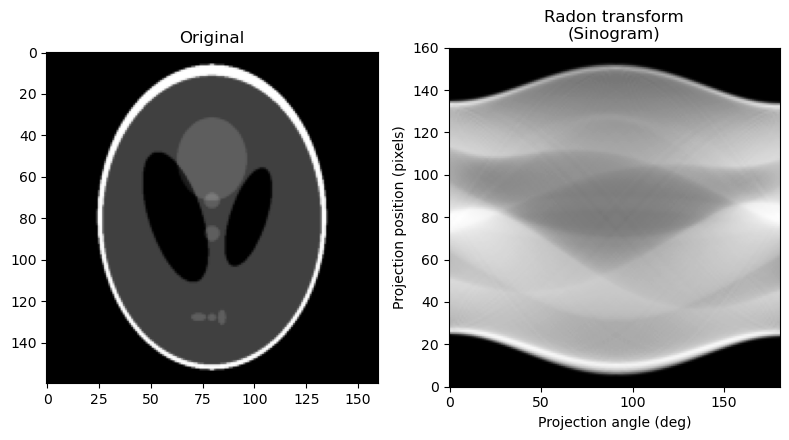

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

**Filtered Back Projection (FBP)** is an image reconstruction technique that uses a filtering process on the sinogram (Radon transform) followed by back-projection to accurately reconstruct the original image.

In [21]:
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')

error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

FBP rms reconstruction error: 0.0283


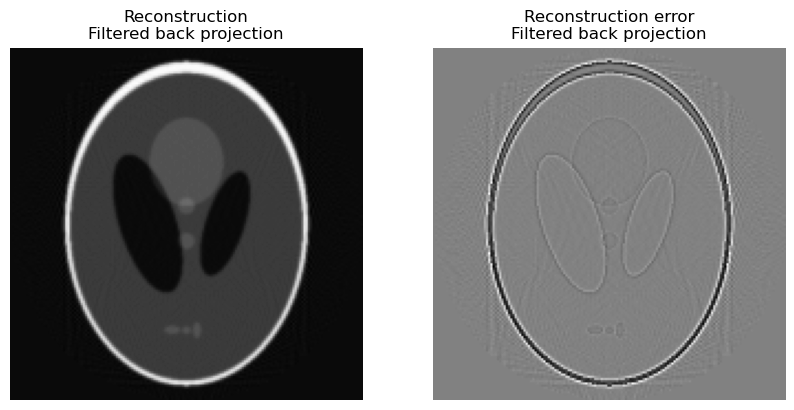

In [ ]:
show_image(["Reconstruction\nFiltered back projection", 
            "Reconstruction error\nFiltered back projection"], 
            reconstruction_fbp, reconstruction_fbp - image)

----